# Analysis of UQ runs - DEMO 2016 initial uncertainties

This notebook is examining the 2016 EU DEMO baseline subject to uncertainties in the aspect ratio and the burn time.
Some other uncertainties from past studies have been included such as the thermal to electric efficiency and the  thermal alpha to electron density and some stress parameters.
We want to see what the optimal aspect ratio is and what parameters PROCESS adjusts to compensate for changes in the aspect ratio.

## Results summary

This design is not very "convergent", we have only achieve 94 converged samples from 1895 sample points. This is a rate of 0.05.

The uncertain parameters which drive this convergence rate are the aspect ratio, the minimum burn time, the thermal to electric efficiency and the theraml alpha/electron ratio.


|   | aspect | tbrnmn   | etath   | ralpne   |
|---|--------|----------|---------|----------|
| Design point | 3.32   | 17542.19 | 0.37    | 0.06857  |
| Optimised point | 2.83   | 15293.11 | 0.39    | 0.07316  |
| Delta | -0.49  | -2249.07 | 0.01863 | 0.00459 |

We can see that reducing the aspect ratio and the burn time produces a device which more readily converges and is more capable of accomodating underperformance in other aspects.


## Import the Uncertainty Data and create object

## Calculate Sensitivity Indices and Reliability

In [1]:
%load_ext autoreload
%autoreload 1
from pathlib import Path
from bokeh.plotting import figure, show
import sys
sys.path.append('/home/graeme/process_uq/')
sys.path.append('/home/graeme/PROCESS_SALib/')
from uq_analysis import UncertaintyData, Copula, CopulaAnalysis
# from bokeh.plotting import figure 
from bokeh.io import output_notebook
output_notebook()
proj_dir = str(Path.cwd())+"/"
proj_dir = "/home/graeme/data/uq_run_data/paper_runs/demo/"
figure_of_merit = "powfmw"
uq_data = UncertaintyData(proj_dir, figure_of_merit,use_scoping_data=False)



Loading BokehJS ...

In [2]:
uq_data.calculate_sensitivity(figure_of_merit)
uq_data.calculate_failure_probability()
print("Number of samples: ", len(uq_data.uncertainties_df))
print("Number of converged runs: ",uq_data.number_of_converged_runs,)
print("Failure Rate: ", uq_data.failure_probability,"+/-", uq_data.failure_cov)


Number of samples:  1895
Number of converged runs:  94
Failure Rate:  0.95 +/- 0.01


## Regional Sensitivity - what causes PROCESS to converge?

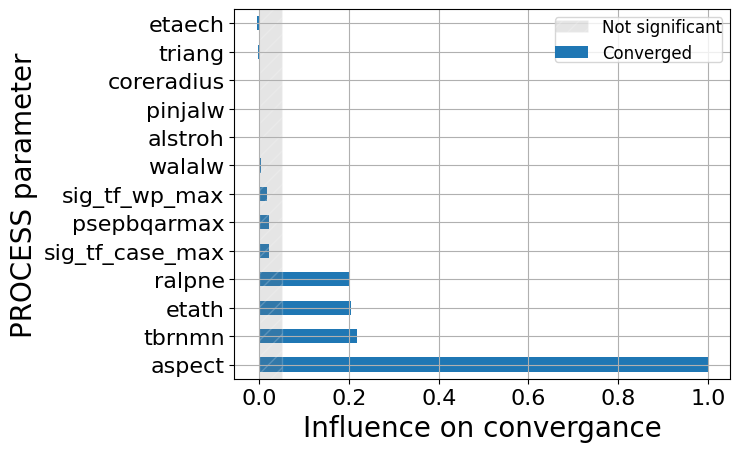

['aspect', 'tbrnmn', 'etath', 'ralpne']


In [3]:
uq_data.convergence_regional_sensitivity_analysis(uq_data.input_names)
uq_data.plot_sumsq_sensitivity()
significant_conv_vars = uq_data.find_significant_parameters(uq_data.sumsq_sensitivity_df,"unconverged",0.1).tolist()
print(significant_conv_vars)

"aspect" = aspect ratio

"tbrnmn" = minimum required burn time

"etath" = electric to thermal conversion efficiency

"ralpne" = thermal alpha/electron density.

## Find the iteration variables which are influential for the significant convergence variables

In [4]:
copula = Copula(uq_data.converged_df,significant_conv_vars,copula_type="unbounded")
copula.calculate_copula(synthetic_sample_size=50000)
copula.calculate_pdf()
copula.copula_data_dict()
pdf_df=copula.create_pdf_df()
copula.find_max_pdf(print_data=False)
copula_correlation_matrix = copula.correlation_matrix()

/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


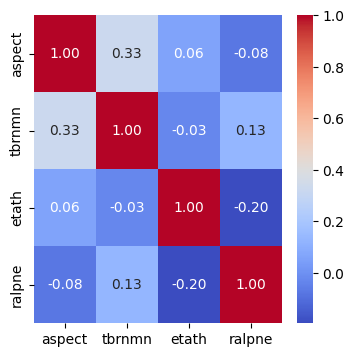

In [5]:
copula.plot_correlation_matrix(copula_correlation_matrix)

There isn't a very strong interaction between this inputs. Aspect ratio and Burn Time are somewhat positively correlated. Etath is somewhat negatively correlated with the other variables.

In [6]:
custom_data = {"aspect":2.8,"etath":0.40,"tbrnmn":10000,"ralpne":0.070}

conv_copula_analysis=CopulaAnalysis(uq_data,copula,num_intervals=10)#,custom_data_point=custom_data)
conv_network= conv_copula_analysis.correlation_network(copula.correlation_matrix(),threshold=0.03,variables=significant_conv_vars)
conv_copula_analysis.plot_network(conv_network,fig_height=500,fig_width=500)
show(conv_copula_analysis.create_graph_grid(significant_conv_vars))
show(conv_copula_analysis.create_datatable(significant_conv_vars))


/home/graeme/process_uq/uq_analysis.py:1406: RuntimeWarning: invalid value encountered in divide
  Delta_C_over_C = np.sqrt((Delta_A / A) ** 2 + (Delta_B / B) ** 2)
/home/graeme/process_uq/uq_analysis.py:1406: RuntimeWarning: invalid value encountered in divide
  Delta_C_over_C = np.sqrt((Delta_A / A) ** 2 + (Delta_B / B) ** 2)


## Create a copula based on the important variables for convergence and iteration variables

In [7]:
all_variables = significant_conv_vars + ["sig_tf_case_max","sig_tf_wp_max","alstroh","rmajor",'bt', 'beta', 'jwptf', 'fcutfsu', 'plhthresh', 'wallmw', 'dene', 'ohcth', 'bore', 'coheof', 'powfmw', 'cohbop', 'te', 'bigq', 'tfcth', 'tdmptf', 'vtfskv']
vars_to_model = []
for item in all_variables:
    if item not in vars_to_model:
        vars_to_model.append(item)
print(vars_to_model)
itv_copula = Copula(uq_data.converged_df,vars_to_model, copula_type="unbounded")
itv_copula.calculate_copula(synthetic_sample_size=50000)
itv_copula.calculate_pdf()
itv_pdf_df=itv_copula.create_pdf_df()
itv_copula.copula_data_dict()

['aspect', 'tbrnmn', 'etath', 'ralpne', 'sig_tf_case_max', 'sig_tf_wp_max', 'alstroh', 'rmajor', 'bt', 'beta', 'jwptf', 'fcutfsu', 'plhthresh', 'wallmw', 'dene', 'ohcth', 'bore', 'coheof', 'powfmw', 'cohbop', 'te', 'bigq', 'tfcth', 'tdmptf', 'vtfskv']


/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [9]:
itv_correlation_matrix = itv_copula.correlation_matrix()
custom_data = {"etath":0.370,"ralpne":0.07}
itv_conv_copula_analysis=CopulaAnalysis(uq_data,itv_copula,num_intervals=10,custom_data_point=custom_data)
itv_correlation_matrix = itv_copula.correlation_matrix()
itv_network = itv_conv_copula_analysis.correlation_network(itv_copula.correlation_matrix(),threshold=0.3,variables=significant_conv_vars)
itv_conv_copula_analysis.plot_network(itv_network)
show(itv_conv_copula_analysis.create_datatable(vars_to_model))


/home/graeme/process_uq/uq_analysis.py:1406: RuntimeWarning: invalid value encountered in divide
  Delta_C_over_C = np.sqrt((Delta_A / A) ** 2 + (Delta_B / B) ** 2)
/home/graeme/process_uq/uq_analysis.py:1406: RuntimeWarning: invalid value encountered in divide
  Delta_C_over_C = np.sqrt((Delta_A / A) ** 2 + (Delta_B / B) ** 2)
/home/graeme/process_uq/uq_analysis.py:1406: RuntimeWarning: invalid value encountered in divide
  Delta_C_over_C = np.sqrt((Delta_A / A) ** 2 + (Delta_B / B) ** 2)
/home/graeme/process_uq/uq_analysis.py:1406: RuntimeWarning: invalid value encountered in divide
  Delta_C_over_C = np.sqrt((Delta_A / A) ** 2 + (Delta_B / B) ** 2)
